# RADICAL-Pilot Tutorial

Utilize the examples below to familiarize yourself with RADICAL-Pilot.

We will:
* Modify settings (environment variables) if needed
* Modify the example to print out the hostname of the machine that runs the Pilot


**Please make sure that you always close the session before terminating the notebook using `session.close()`**

## 1 RADICAL-Pilot Setup

Documentation: http://radicalpilot.readthedocs.org/en/latest/machconf.html#preconfigured-resources

First, we will import the necessary dependencies and define some helper functions.

In [40]:
%matplotlib inline
import os, sys
import commands
import radical.pilot as rp
import random
import pandas as pd
import ast
import seaborn as sns

def print_details(detail_object):
    if type(detail_object)==str:
        detail_object = ast.literal_eval(detail_object)
    for i in detail_object:
        detail_object[i]=str(detail_object[i])
    return pd.DataFrame(detail_object.values(), 
             index=detail_object.keys(), 
             columns=["Value"])

os.environ["RADICAL_PILOT_VERBOSE"]="ERROR"
os.environ["RADICAL_PILOT_DBURL"]="mongodb://mongo.radical-cybertools.org:24242/sc15-test000"

!/opt/anaconda/bin/radicalpilot-version

0.37.11.2


## 2. Local Pilot Example

This example shows how to execute a task using a Pilot-Job running on the local machine. In this case, the Pilot-Job is started using **ssh** on the edge node machine of the Hadoop cluster (which runs Jupyterhub - the iPython notebook server).

### 2.1 Create a new Session and Pilot-Manager. 

In [41]:
session = rp.Session()
pmgr = rp.PilotManager(session=session)
umgr = rp.UnitManager (session=session,
                       scheduler=rp.SCHED_ROUND_ROBIN)
print "Session id: %s Pilot Manager: %s" % (session.uid, str(pmgr.as_dict()))

Session id: rp.session.ip-10-144-47-195.radical.016754.0000 Pilot Manager: {'uid': 'pmgr.0003'}


In [42]:
print_details(umgr.as_dict())

,Value
uid,umgr.0003
scheduler,RoundRobinScheduler
scheduler_details,NO SCHEDULER DETAILS (Not Implemented)


### 2.2 Submit Pilot and add to Unit Manager

In [43]:
pdesc = rp.ComputePilotDescription()
pdesc.resource = "local.localhost_anaconda"  # NOTE: This is a "label", not a hostname
pdesc.runtime  = 10 # minutes
pdesc.cores    = 2
pdesc.cleanup  = False
pilot = pmgr.submit_pilots(pdesc)
umgr.add_pilots(pilot)

In [44]:
print_details(pilot.as_dict())

,Value
uid,pilot.0003
stdout,None
start_time,None
resource_detail,"{'cores_per_node': None, 'nodes': None}"
submission_time,1447558788.79
logfile,None
resource,local.localhost_anaconda
log,[]
sandbox,file://localhost/home/radical/radical.pilot.sa...
state,PendingLaunch


### 2.3 Submit Compute Units

Create a description of the compute unit, which specifies the details of the task to be executed.

In [45]:
cudesc = rp.ComputeUnitDescription()
cudesc.environment = {'CU_NO': 1}
cudesc.executable  = "/bin/echo"
cudesc.arguments   = ['I am CU number $CU_NO']
cudesc.cores       = 1
print_details(cudesc.as_dict())

,Value
kernel,None
executable,/bin/echo
name,None
restartable,False
output_staging,None
stdout,None
pre_exec,None
mpi,False
environment,{'CU_NO': 1}
cleanup,False


Submit the previously created ComputeUnit descriptions to the PilotManager. This will trigger the selected scheduler (in this case the round-robin scheduler) to start assigning ComputeUnits to the ComputePilots.

In [46]:
print "Submit Compute Units to Unit Manager ..."
cu_set = umgr.submit_units([cudesc])
print "Waiting for CUs to complete ..."
umgr.wait_units()
print "All CUs completed successfully!"
cu_results = cu_set[0]
details=cu_results.as_dict()

Submit Compute Units to Unit Manager ...
Waiting for CUs to complete ...
All CUs completed successfully!


---
The next command will provide the state of the Pilot and other pilot details.

In [47]:
print_details(details)

,Value
log,[<radical.pilot.logentry.Logentry object at 0x...
state,Done
working_directory,file://localhost/home/radical/radical.pilot.sa...
uid,unit.000023
submission_time,1447558788.94
execution_details,"{u'control': u'umgr', u'stdout': u'I am CU num..."
stop_time,None
start_time,None
exit_code,0
name,None


And some more details...

In [48]:
print_details(details["execution_details"])

,Value
control,umgr
stdout,I am CU number 1\n
callbackhistory,"[{u'timestamp': 1447558789.332482, u'state': u..."
Agent_Output_Directives,[]
Agent_Output_Status,None
Agent_Input_Status,None
exec_locs,None
FTW_Input_Directives,[]
log,"[{u'timestamp': 1447558788.957515, u'message':..."
exit_code,0


Parse the output of the CU

In [49]:
print cu_results.stdout.strip()

I am CU number 1


### 2.4 Exercise

Write a task (i.e., a ComputeUnit) that prints out the hostname of the machine!

Answer: In the example above, in cudesc.executable replace `/bin/echo` with `hostname`.

### 2.5 Performance Analysis

In the examples below we will show how RADICAL-Pilot can be used for interactive analytics. We will plot and analyze the execution times of a set of ComputeUnits.

In [50]:
def get_runtime(compute_unit):
    details=compute_unit.as_dict()
    execution_details=details['execution_details']
    state_details=execution_details["statehistory"]
    results = {}
    for i in state_details:
        results[i["state"]]=i["timestamp"]
    start = results["Scheduling"]
    end = results["Done"]
    runtime = end-start
    return runtime

In [51]:
import random
cudesc_list = []
for i in range(20):
    cudesc = rp.ComputeUnitDescription()
    cudesc.executable  = "/bin/sleep"
    cudesc.environment = {'CU_NO': i}
    cudesc.arguments   = ['%d'%(random.randrange(10))]
    cudesc.cores       = 1
    cudesc_list.append(cudesc)

In [52]:
cu_set = umgr.submit_units(cudesc_list)

In [53]:
states = umgr.wait_units()

In [54]:
runtimes=[]
for compute_unit in cu_set:
    str(compute_unit)
    runtimes.append(get_runtime(compute_unit))

`/bin/sleep` assigns a random sleep time. We plot the distribution of runtimes of the above 20 ComputeUnits using [Seaborn](http://stanford.edu/~mwaskom/software/seaborn/). See [distplot documentation](http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.distplot.html?highlight=distplot).

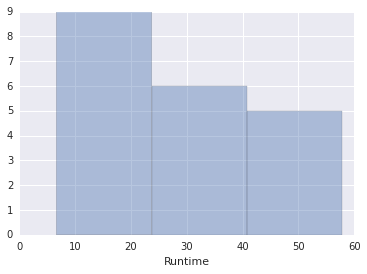

In [70]:
plot=sns.distplot(runtimes, kde=False, axlabel="Runtime")

### 2.6 Close and Delete Session 

In [56]:
session.close()
del session

## 3. YARN Pilot Example

Having submitted multiple jobs using RADICAL-Pilot locally, in this section we will examine how to submit multiple tasks to a YARN cluster using RADICAL-Pilot. Although not of primary importance for this tutorial, it is worth noting that the YARN cluster is a remote resource compared to the submission host (edge node).

### 3.1 Create a new Session and Pilot-Manager. 


In [57]:
import getpass
yarn_session = rp.Session()
c = rp.Context('ssh')
c.user_id = getpass.getuser()
yarn_session.add_context(c)
pmgr = rp.PilotManager(session=yarn_session)
umgr = rp.UnitManager(session=yarn_session,
                      scheduler=rp.SCHED_ROUND_ROBIN)
print "Session id: %s Pilot Manager: %s" % (yarn_session.uid, str(pmgr.as_dict()))

Session id: rp.session.ip-10-144-47-195.radical.016754.0001 Pilot Manager: {'uid': 'pmgr.0004'}


### 3.2 Submit Pilot and add to Unit Manager

Note the change in the resource description:

        pdesc.resource = "yarn.aws-vm"  # NOTE: This is a "label", not a hostname

In [58]:
pdesc = rp.ComputePilotDescription ()
pdesc.resource = "yarn.aws-vm"  # NOTE: This is a "label", not a hostname
pdesc.runtime  = 30 # minutes
pdesc.cores    = 1
pdesc.cleanup  = False
# submit the pilot.
print "Submitting Compute Pilot to Pilot Manager ..."
pilot = pmgr.submit_pilots(pdesc)
umgr.add_pilots(pilot)

Submitting Compute Pilot to Pilot Manager ...


In [59]:
print_details(pilot.as_dict())

,Value
uid,pilot.0004
stdout,None
start_time,None
resource_detail,"{'cores_per_node': None, 'nodes': None}"
submission_time,1447558875.1
logfile,None
resource,yarn.aws-vm
log,[]
sandbox,sftp://sc15.radical-cybertools.org/home/radica...
state,PendingLaunch


### 3.3 Submit Compute Units

Create a description of the compute unit, which specifies the details on the executed task.

In [60]:
cudesc = rp.ComputeUnitDescription()
cudesc.environment = {'CU_NO': "1"}
cudesc.executable  = "/bin/echo"
cudesc.arguments   = ['I am CU number $CU_NO']
cudesc.cores       = 1
print_details(cudesc.as_dict())

,Value
kernel,None
executable,/bin/echo
name,None
restartable,False
output_staging,None
stdout,None
pre_exec,None
mpi,False
environment,{'CU_NO': '1'}
cleanup,False


Submit the previously created ComputeUnit descriptions to the PilotManager. This will trigger the selected scheduler to start assigning ComputeUnits to the ComputePilots.

In [61]:
print "Submit Compute Units to Unit Manager ..."
cu_set = umgr.submit_units([cudesc])
print "Waiting for CUs to complete ..."
umgr.wait_units()
print "All CUs completed successfully!"
cu_results = cu_set[0]
details=cu_results.as_dict()

Submit Compute Units to Unit Manager ...
Waiting for CUs to complete ...
All CUs completed successfully!


In [62]:
print_details(details)

,Value
log,[<radical.pilot.logentry.Logentry object at 0x...
state,Done
working_directory,sftp://sc15.radical-cybertools.org/home/radica...
uid,unit.000044
submission_time,1447558875.28
execution_details,"{u'control': u'umgr', u'stdout': u'[... CONTEN..."
stop_time,None
start_time,None
exit_code,0
name,None


In [63]:
print_details(details["execution_details"])

,Value
control,umgr
stdout,[... CONTENT SHORTENED ...]\notobufRpcEngine:2...
callbackhistory,"[{u'timestamp': 1447558876.250819, u'state': u..."
Agent_Output_Directives,[]
Agent_Output_Status,None
Agent_Input_Status,None
exec_locs,None
FTW_Input_Directives,[]
log,"[{u'timestamp': 1447558875.294721, u'message':..."
exit_code,0


In [64]:
print cu_results.stdout.strip()

[... CONTENT SHORTENED ...]
otobufRpcEngine:250 - Call: getApplicationReport took 1ms
2015-11-15 03:41:44 DEBUG Client:1032 - IPC Client (1561421084) connection to /10.63.179.69:8050 from radical sending #530
2015-11-15 03:41:44 DEBUG Client:1089 - IPC Client (1561421084) connection to /10.63.179.69:8050 from radical got value #530
2015-11-15 03:41:44 DEBUG ProtobufRpcEngine:250 - Call: getApplicationReport took 0ms
2015-11-15 03:41:44 DEBUG Client:1032 - IPC Client (1561421084) connection to /10.63.179.69:8050 from radical sending #531
2015-11-15 03:41:44 DEBUG Client:1089 - IPC Client (1561421084) connection to /10.63.179.69:8050 from radical got value #531
2015-11-15 03:41:44 DEBUG ProtobufRpcEngine:250 - Call: getApplicationReport took 0ms
2015-11-15 03:41:44 INFO  Client:792 - Application has completed successfully. Breaking monitoring loop
2015-11-15 03:41:44 INFO  Client:240 - Application completed successfully
2015-11-15 03:41:44 DEBUG Client:97 - stopping client from cache: or

## 4. Close and Delete Session

In [65]:
yarn_session.close()
del yarn_session